# Finetune Bert

## Библиотеки и настройки

In [1]:
# установить библиотеки в случае их отсутствия
# pip install pandas
# pip install numpy
# pip install scikit-learn
# pip install PyYAML
# pip install torch
# pip install transformers
import re
import random
import numpy as np
import pandas as pd
import json
import yaml
import torch

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from typing import List, Mapping, Tuple
from collections import Counter
from tqdm import tqdm

from train_nn import run
from bert_model import BertForSequenceClassification


In [2]:
torch.manual_seed(13)

# Выводим информацию о версии CUDA
print(f"Версия CUDA: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")


Версия CUDA: 12.1
Используемое устройство: cuda


In [3]:
WORDS_KEYS_SET = {
    'доверенность',
    'договор',
    'акт',
    'заявление',
    'приказ',
    'счет',
    'приложение',
    'соглашение',
    'договор'
    'оферты',
    'устав',
    'решение'
}


## Вспомогательные классы и функции

In [4]:
# Класс для подготовки датасета
class TextClassificationDataset(Dataset):

    def __init__(
        self,
        texts: List[str],
        labels: List[int] = None,
        labels_dict: Mapping[str,str] = None,
        max_seq_length: int = 128,
        model_name: str = None,
        add_spec_tokens: bool = False):

        """
        Args:
            texts: a list of text to classify
            labels: a list with classification labels
            labels_dict: a dictionary mapping class names to class ids
            max_seq_length: maximum sequence length in tokens
            model_name: transformer model name
            add_spec_tokens: if we want to add special tokens to the tokenizer
        """

        self.texts = texts
        self.labels = labels
        self.labels_dict = labels_dict
        self.max_seq_length = max_seq_length

        if (self.labels_dict is None and labels is not None):
            self.labels_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, index : int) -> Mapping[str, torch.Tensor]:
        """
        Gets encoded representation of a single element (text) in the dataset
        Args:
            index (int): index of the element in dataset
        Returns:
            Single element by index
        """
        text = self.texts[index]

        encoded_dict = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_seq_length,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt',
        )

        encoded_dict["features"] = encoded_dict["input_ids"].squeeze(0)
        del encoded_dict["input_ids"]
        del encoded_dict["token_type_ids"]

        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.labels_dict.get(y, -1)]).long().squeeze(0)
            encoded_dict["targets"] = y_encoded

        return encoded_dict

def read_data(cfg: dict) -> Tuple[dict, dict, dict]:
    """
    Function that reads text data, creates TextClassificationDatasets and DataLoaders.
    Args:
        A config dictionary containing "file_path", "max_seq_length", etc...
    Returns:
        A tuple with (training & validation), testing, unlabeled_inference DataLoader dictionaries
    """
    train_dataset = TextClassificationDataset(
        texts=train_sentences['text'].values.tolist(),
        labels=train_sentences['label'].values,
        max_seq_length=cfg['model']['max_seq_length'],
        model_name=cfg['model']['model_name'],
    )

    val_dataset = TextClassificationDataset(
        texts=test_sentences['text'].values.tolist(),
        labels=test_sentences['label'].values,
        max_seq_length=cfg['model']['max_seq_length'],
        model_name=cfg['model']['model_name'],
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=cfg['training']['batch_size'],
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        sampler=SequentialSampler(val_dataset),
        batch_size=cfg['training']['batch_size'],
    )

    return train_loader, val_loader


In [5]:

def del_process_text(text):
    """
    удаляем в тексте ненужные подчеркивания и данные в скобках
    """
    text = re.sub("_+", "", text)
    text = re.sub("\([^)]*\)", "", text)
    text = text.lower()

    return text


def del_clauses_process_text(sequences):
    """
    удаляем пункты договора
    """
    res = [re.sub("\n", "", x) for x in sequences]
    res = [re.sub(r'\s+', ' ', x).strip() for x in sequences]

    return res


def splitting_text_regex(text, splitter='[\t\n]\s*\d+[0-9\.]*\.\s'):
    """
    Сплитим regex по пунктам договора
    """
    # Если не находит пункты, то пусть делит по абзацам
    points = re.findall(splitter, text)
    res = re.split(splitter, text)

    return res, points

def generate_random_10_digit_number():
    """
    Генератор случайных 10 цифр
    """
    return random.randint(10**9, 10**10 - 1)


In [6]:
def sentences_create(data, content_col="text", label_col="label", id_col="doc_id"):
    """
    Из df с договорами создает большой df пунктов и лейблов к ним
    """
    text_data = []
    labels_data = []
    id_data = []

    for index in range(data.shape[0]):
        row = data.iloc[index]
        splitted_text, splitting_points = splitting_text_regex(del_process_text(row[content_col]))
        if len(splitted_text) < 5:
            splitted_text_by_enter = []
            for text in splitted_text:
                splitted_text_by_enter.extend(text.split('\n'))
            splitted_text = splitted_text_by_enter

        splitted_text_by_enter = []
        for text in splitted_text:
            if len(text.split(' ')) > 600: # > 600 слов => разбиение по \n
                splitted_text_by_enter.extend(text.split('\n'))
            else:
                splitted_text_by_enter.append(text)

        splitted_text = splitted_text_by_enter

        processed_splitted_text = del_clauses_process_text(splitted_text)

        text_data += processed_splitted_text

        labels_data.extend(row[label_col] for x in range(len(processed_splitted_text)))
        id_data.extend(re.sub(r"\.+[^\n]+", "", row[id_col]) for x in range(len(processed_splitted_text)))

    sentences = pd.DataFrame({"text": text_data, "label": labels_data, "id": id_data})

    filtered = sentences[
        sentences["text"].apply(lambda x: (len(x.split(" ")) > 5) | (len(set(x.split(" ")).intersection(set(WORDS_KEYS_SET))) > 0))
        ].reset_index(drop=True)

    return filtered


## Получение данных по документам

### НАДО ЗАМЕНИТЬ ИЛИ УДАЛИТЬ
import gdown

url = 'https://drive.google.com/file/d/1zfdnovlwsAyuv6NaWrNUBfgZxD-Fq3kG/view?usp=share_link'
gdown.download(url, "to_gdrive1.zip", fuzzy=True)
#unzip '/content/to_gdrive1.zip'


In [7]:
#словарь лейблов
with open('labels.json', 'r', encoding='utf8') as f:
    kind_names = json.load(f)
kind_names
kind_names = {v : int(i) for i, v in kind_names.items()}
kind_names


{'arrangement': 0,
 'application': 1,
 'proxy': 2,
 'contract': 3,
 'act': 4,
 'order': 5,
 'determination': 6,
 'statute': 7,
 'contract offer': 8,
 'invoice': 9,
 'bill': 10}

In [8]:
df = pd.read_csv("sample.csv")
df.sample(7)


,class,text
0,arrangement,СОГЛАШЕНИЕ N 8\nо расторжении трудового догово...
33,arrangement,Соглашение\n\nо добровольном возмещении ущерба...
154,proxy,Д О В Е Р Е Н Н О С Т Ь\nг. Марс\nПервого янва...
321,order,ООО «Зеленая планета»\r\nПриказ №44\r\nг. Моск...
440,invoice,\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...
7,arrangement,Соглашение № 23\n\nО расторжении договора арен...
422,invoice,"Дорожная ведомость (для перевозчика, выдающег..."


In [9]:
df['doc_id'] = df['text'].map(lambda x : str(generate_random_10_digit_number()))
df["label"] = df["class"].map(kind_names)
print('Кол-во уникальных значений в doc_id', len(df.doc_id.unique()))
df.sample(7)


Кол-во уникальных значений в doc_id 501


,class,text,doc_id,label
153,proxy,Д О В Е Р Е Н Н О С Т Ь\nг. Марс\nПервого янва...,3197116015,2
170,proxy,Д О В Е Р Е Н Н О С Т Ь\nг. Марс\nПервого янва...,2265295531,2
54,application,Начальнику управления соцзащиты по Курганской ...,4646937194,1
253,act,АКТ-ДОПУСК\nдля производства строительно-монта...,4003011010,4
187,contract,Договор аренды компрессора\nг. Владивосток 21 ...,7105833795,3
0,arrangement,СОГЛАШЕНИЕ N 8\nо расторжении трудового догово...,6407400315,0
385,statute,УТВЕРЖДЕН\r\nрешением Общего собрания участник...,7513515473,7


## Finetune ```Bert```, с cross validation (на 5-Fold с стратифицикацией)

In [10]:
#загружаем конфиг
with open("config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)


Read successful
{'data': {'train_size': 0.8, 'val_size': 0.2}, 'model': {'model_name': 'IlyaGusev/rubert_telegram_headlines', 'max_seq_length': 128, 'num_classes': 11, 'dropout': 0.2}, 'training': {'learning_rate': '1e-5', 'adam_epsilon': '1e-8', 'num_epochs': 5, 'batch_size': 24}, 'general': {'seed': 13}}


0it [00:00, ?it/s]


Fold 0:

  Train: сэмплов - 400

  Test:  сэмплов - 101



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch = 0



Validating: 100%|██████████| 58/58 [00:06<00:00,  9.44it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 8, 0, 0, 8, 4, 1, 4, 1, 1, 1, 1, 2, 5, 4, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 4, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 8]
Validation acc = 0.8613861386138614; F1 = 0.8443352540104945
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      0.46      0.63        13
           2       0.82      1.00      0.90        14
           3       0.93      1.00      0.97        14
           4       0

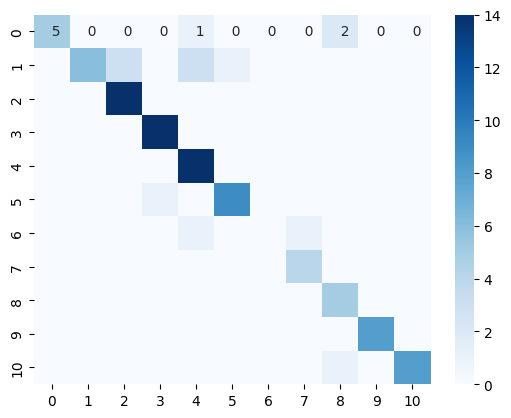

=> Saving checkpoint at epoch 0



Epoch = 1



Validating: 100%|██████████| 58/58 [00:05<00:00,  9.67it/s]

y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 8, 0, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 8]
Validation acc = 0.9504950495049505; F1 = 0.9417487126863947
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       0

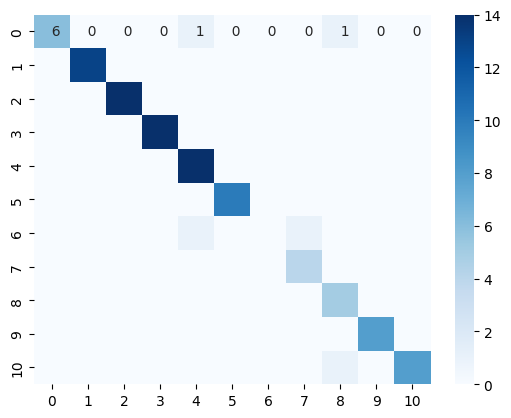

=> Saving checkpoint at epoch 1



Epoch = 2



Validating: 100%|██████████| 58/58 [00:06<00:00,  9.59it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 8, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 8]
Validation acc = 0.9603960396039604; F1 = 0.9535041739468065
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1

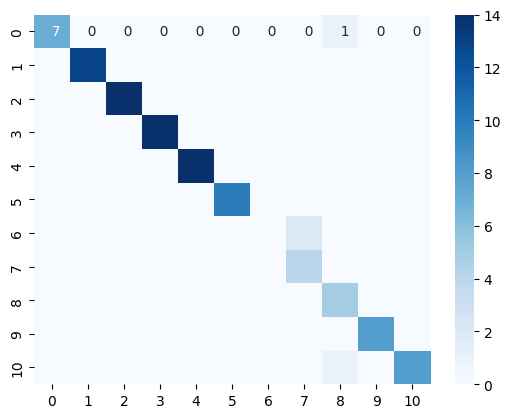

=> Saving checkpoint at epoch 2



Epoch = 3



Validating: 100%|██████████| 58/58 [00:06<00:00,  9.32it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 8, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 8]
Validation acc = 0.9603960396039604; F1 = 0.9535041739468065

Epoch = 4



100%|██████████| 5/5 [07:35<00:00, 91.14s/it]
1it [07:39, 459.66s/it]

y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 8, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 8]
Validation acc = 0.9603960396039604; F1 = 0.9535041739468065

Fold 1:

  Train: сэмплов - 401

  Test:  сэмплов - 100



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch = 0



Validating: 100%|██████████| 58/58 [00:06<00:00,  9.54it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 3, 3, 3, 3, 0, 0, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 9, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 9, 10]
Validation acc = 0.85; F1 = 0.836118760840123
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       1.00      0.83      0.91        12
           2       0.93      0.93      0.93        15
           3       0.70      1.00      0.82        14
           4       0.91      0.77      0.8

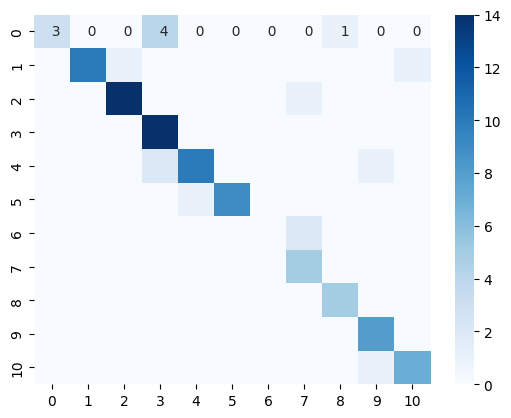

=> Saving checkpoint at epoch 0



Epoch = 1



Validating: 100%|██████████| 58/58 [00:06<00:00,  9.51it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.96; F1 = 0.9518819964349378
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        14
           4       1.00      0.92      0.

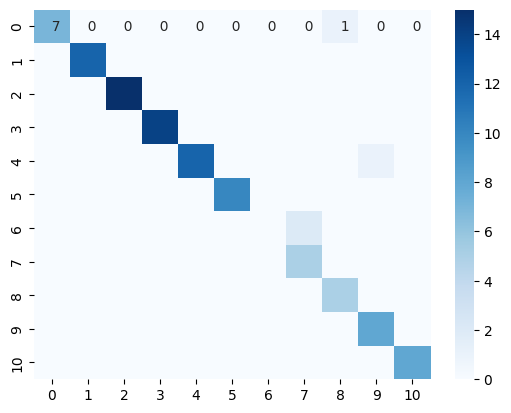

=> Saving checkpoint at epoch 1



Epoch = 2



Validating: 100%|██████████| 58/58 [00:06<00:00,  8.52it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 3, 0, 0, 0, 0, 0, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.95; F1 = 0.940959172132803

Epoch = 3



Validating: 100%|██████████| 58/58 [00:06<00:00,  8.95it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.96; F1 = 0.9518819964349378

Epoch = 4



100%|██████████| 5/5 [07:56<00:00, 95.22s/it]
2it [15:39, 471.74s/it]

y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 4, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.95; F1 = 0.9417878787878787

Fold 2:

  Train: сэмплов - 401

  Test:  сэмплов - 100



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch = 0



Validating: 100%|██████████| 60/60 [00:06<00:00,  9.12it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [8, 0, 4, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 10, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.91; F1 = 0.8999529390300183
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       1.00      1.00      1.00        12
           2       1.00      0.93      0.96        14
           3       0.93      1.00      0.97        14
           4       0.80      0.86      0

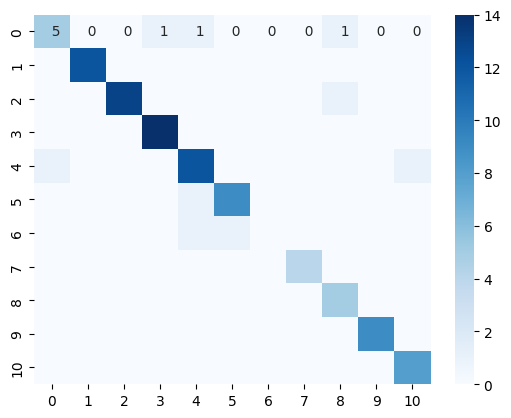

=> Saving checkpoint at epoch 0



Epoch = 1



Validating: 100%|██████████| 60/60 [00:06<00:00,  9.16it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [8, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 4, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.96; F1 = 0.9509085991763477
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       0.93      1.00      0.

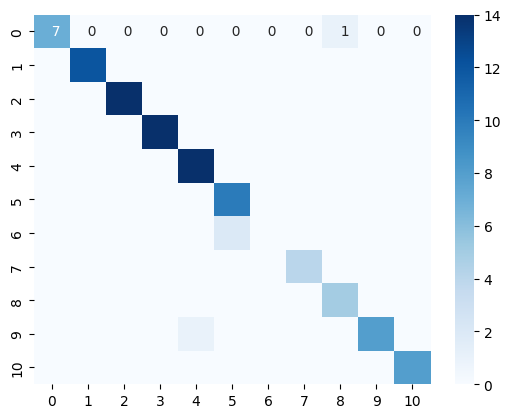

=> Saving checkpoint at epoch 1



Epoch = 2



Validating: 100%|██████████| 60/60 [00:06<00:00,  9.19it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 4, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.96; F1 = 0.9510868347338937
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       0.88      1.00      0.

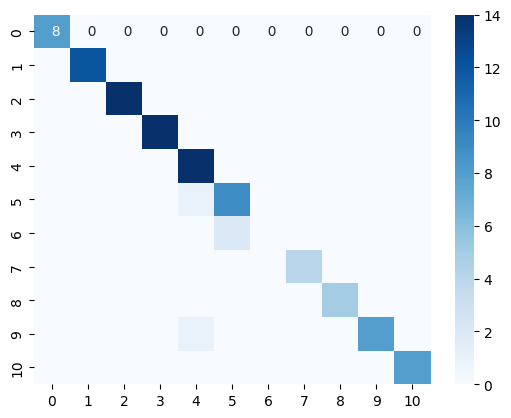

=> Saving checkpoint at epoch 2



Epoch = 3



Validating: 100%|██████████| 60/60 [00:06<00:00,  9.37it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 4, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.97; F1 = 0.9607873870551356
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       0.93      1.00      0.

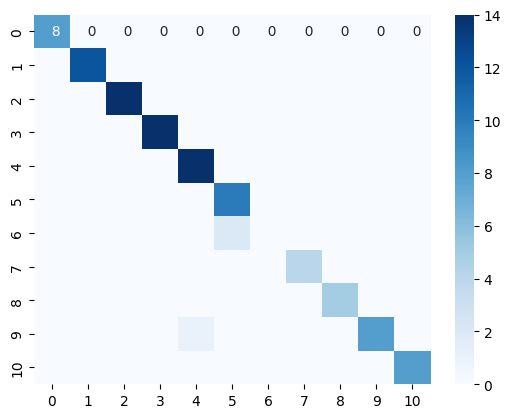

=> Saving checkpoint at epoch 3



Epoch = 4



100%|██████████| 5/5 [07:49<00:00, 93.88s/it]
3it [23:32, 472.33s/it]

y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 4, 9, 9, 10, 10, 10, 10, 10, 10, 10, 4]
Validation acc = 0.96; F1 = 0.9509483065953654

Fold 3:

  Train: сэмплов - 401

  Test:  сэмплов - 100



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch = 0



Validating: 100%|██████████| 63/63 [00:06<00:00,  9.19it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [4, 3, 4, 3, 0, 8, 3, 4, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.78; F1 = 0.7409908549605061
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       1.00      0.75      0.86        12
           2       0.87      0.93      0.90        14
           3       0.82      1.00      0.90        14
           4       0.48      0.93      0.

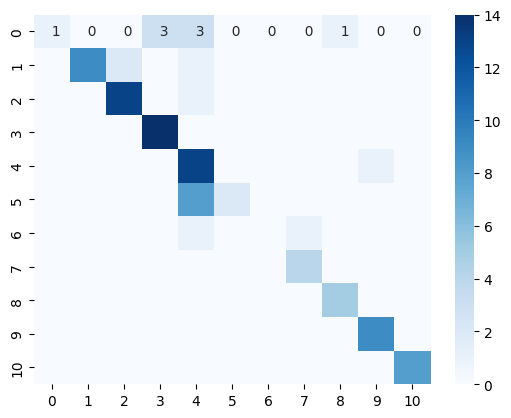

=> Saving checkpoint at epoch 0



Epoch = 1



Validating: 100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 3, 0, 8, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.95; F1 = 0.94007001132228
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       0.93      1.00      0.97        14
           4       1.00      0.93      0.96

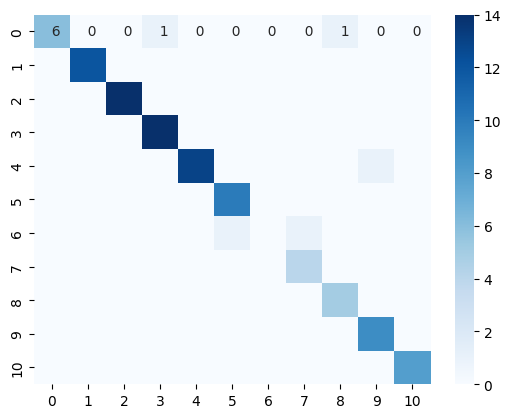

=> Saving checkpoint at epoch 1



Epoch = 2



Validating: 100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.99; F1 = 0.9885714285714287
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.

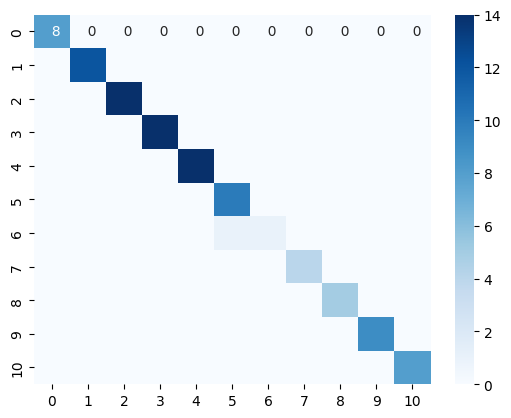

=> Saving checkpoint at epoch 2



Epoch = 3



Validating: 100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 8, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.98; F1 = 0.9786926406926407

Epoch = 4



100%|██████████| 5/5 [07:48<00:00, 93.73s/it]
4it [31:25, 472.32s/it]

y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.99; F1 = 0.9885714285714287

Fold 4:

  Train: сэмплов - 401

  Test:  сэмплов - 100



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch = 0



Validating: 100%|██████████| 56/56 [00:05<00:00,  9.44it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [8, 0, 0, 10, 8, 0, 3, 0, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 2, 2, 4, 2, 2, 9, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 10, 9, 10, 7, 4, 4, 4, 10, 4, 7, 4, 4, 4, 4, 4, 5, 10, 4, 4, 5, 4, 4, 4, 4, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.71; F1 = 0.6887716548424352
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       1.00      0.58      0.74        12
           2       0.73      0.79      0.76        14
           3       0.93      1.00      0.97        14
           4       0.44      0.57  

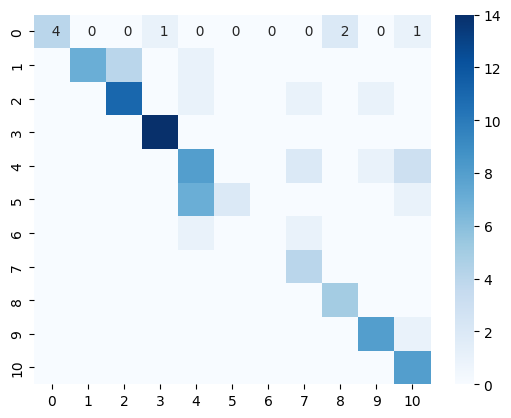

=> Saving checkpoint at epoch 0



Epoch = 1



Validating: 100%|██████████| 56/56 [00:05<00:00,  9.69it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 4, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 10, 4, 10, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 10, 5, 0, 5, 5, 5, 5, 4, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.92; F1 = 0.9131503267973856
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       0.86      0.86    

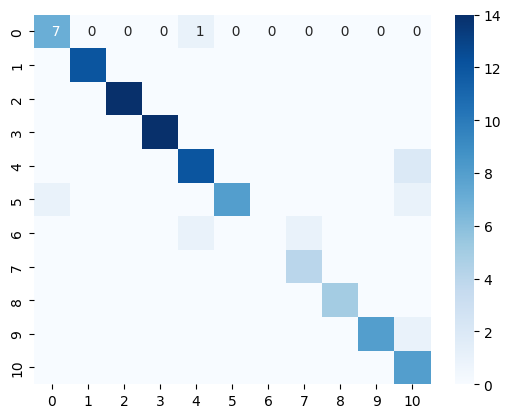

=> Saving checkpoint at epoch 1



Epoch = 2



Validating: 100%|██████████| 56/56 [00:05<00:00,  9.40it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 10, 5, 0, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.94; F1 = 0.9321364522417155
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      0.93      

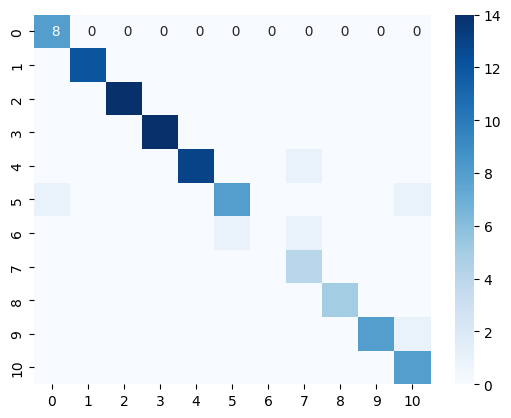

=> Saving checkpoint at epoch 2



Epoch = 3



Validating: 100%|██████████| 56/56 [00:05<00:00,  9.50it/s]


y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 10, 5, 0, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 4, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.93; F1 = 0.9288589324618737

Epoch = 4



100%|██████████| 5/5 [07:50<00:00, 94.06s/it]
5it [39:19, 471.92s/it]

y_test - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
choice_data - [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 10, 5, 0, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 4, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Validation acc = 0.93; F1 = 0.9288589324618737


In [11]:
kf = StratifiedKFold (n_splits=5, shuffle = True, random_state=13)
kf.get_n_splits(df[["text", "doc_id"]], df['label'])

# train запускается по количеству настраиваемых эпох на каждом из 5 фолдов
# поменять можно в cfg.yaml число num_epochs

for i, (train_index, test_index) in tqdm(enumerate(kf.split(df[["text", "doc_id"]], df['label']))):
    print()
    print("====================================")
    print(f"Fold {i}:")
    print("====================================\n")
    print(f"  Train: сэмплов - {len(train_index)}\n")
    print(f"  Test:  сэмплов - {len(test_index)}\n")

    train_sentences = sentences_create(pd.concat([
      df[["text", "doc_id"]].iloc[train_index],
      df['label'].iloc[train_index]
      ], axis=1))
    test_sentences = sentences_create(pd.concat([
      df[["text", "doc_id"]].iloc[test_index],
      df['label'].iloc[test_index]
      ], axis=1))

    train_dataloader, val_dataloader = read_data(cfg)

    train_losses = []
    val_losses = []
    F1_scores = []
    accuracy_scores = []

    model = BertForSequenceClassification(
        pretrained_model_name='DeepPavlov/rubert-base-cased',
        num_labels=cfg['model']['num_classes'], # 11
        dropout=cfg['model']['dropout'] # 0.2
    )

    run(model=model,
      cfg=cfg,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      unlabeled_dataloader=None,
      test_sentences=test_sentences,
      y_test=df['label'].iloc[test_index].to_list(),
      train_losses=train_losses,
      val_losses=val_losses,
      F1_scores=F1_scores,
      accuracy_scores=accuracy_scores,
    )


## Сохраним лучшие веса модели 

In [13]:
model_save_name = 'Ru-bert-Pavlov-Gusev-fine-tuned.pt'
path = F"{model_save_name}"
torch.save(model.state_dict(), path)
